In [ ]:
%pip install sf-hamilton[visualization]

# Modular Pipeline Example [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dagworks-inc/hamilton/blob/main/examples/model_examples/modular_example/notebook.ipynb) [![GitHub badge](https://img.shields.io/badge/github-view_source-2b3137?logo=github)](https://github.com/dagworks-inc/hamilton/blob/main/examples/model_examples/modular_example/notebook.ipynb)
This uses the jupyter magic commands to create a simple example of how to reuse pipelines in a modular manner with subdag. 

In [1]:
%load_ext hamilton.plugins.jupyter_magic

/Users/stefankrawczyk/.pyenv/versions/knowledge_retrieval-py39/lib/python3.9/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


# Define features module

This is the common data preprocessing step.

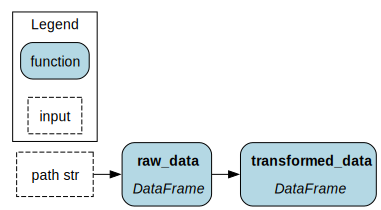

In [2]:
%%cell_to_module features --display

import pandas as pd

def raw_data(path: str) -> pd.DataFrame:
    return pd.read_csv(path)

def transformed_data(raw_data: pd.DataFrame) -> pd.DataFrame:
    return raw_data.dropna()

# Define train module

This is the training bit of the dataflow.

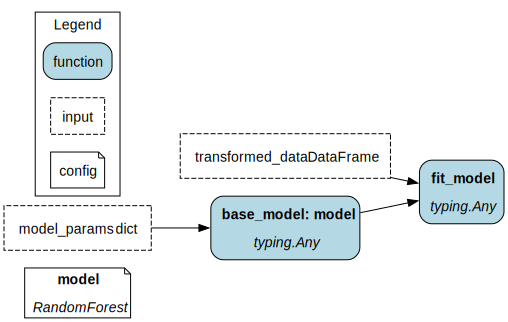

In [3]:
%%cell_to_module train --config '{"model":"RandomForest"}'--display

from typing import Any
import pandas as pd

from hamilton.function_modifiers import config

@config.when(model="RandomForest")
def base_model__rf(model_params: dict) -> Any:
    from sklearn.ensemble import RandomForestClassifier
    return RandomForestClassifier(**model_params)

@config.when(model="LogisticRegression")
def base_model__lr(model_params: dict) -> Any:
    from sklearn.linear_model import LogisticRegression
    return LogisticRegression(**model_params)

@config.when(model="XGBoost")
def base_model__xgb(model_params: dict) -> Any:
    from xgboost import XGBClassifier
    return XGBClassifier(**model_params)


def fit_model(transformed_data: pd.DataFrame, base_model: Any) -> Any:
    """Fit a model to transformed data."""
    base_model.fit(transformed_data.drop("target", axis=1), transformed_data["target"])
    return base_model


# Define the inference module

This houses what we need for inference.

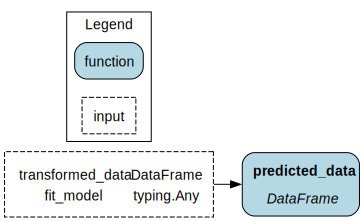

In [4]:
%%cell_to_module inference --display
from typing import Any
import pandas as pd


def predicted_data(transformed_data: pd.DataFrame, fit_model: Any) -> pd.DataFrame:
    return fit_model.predict(transformed_data)



# We can combine the modules independently with different drivers

But this won't provide us with a single dataflow or DAG.

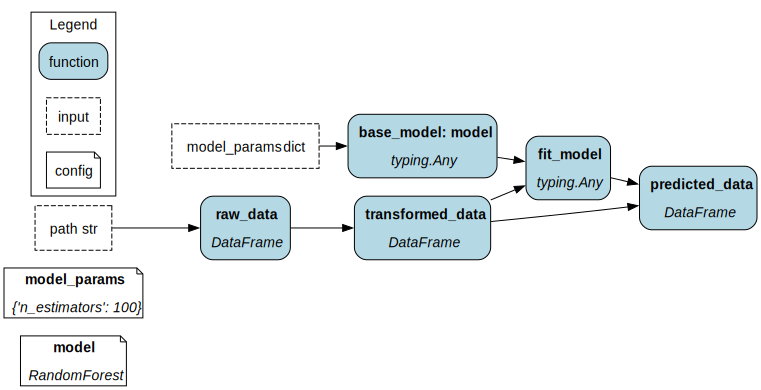

In [9]:
# train
from hamilton import driver

train_dr = (
    driver.Builder()
    .with_config({"model": "RandomForest", "model_params": {"n_estimators": 100}})
    .with_modules(features, train, inference)
    .build()
)
train_dr.display_all_functions()

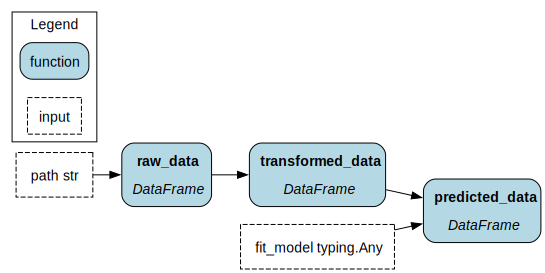

In [10]:
# Inference
from hamilton import driver

inference_dr = (
    driver.Builder()
    .with_config({})
    .with_modules(features, inference)
    .build()
)
inference_dr.display_all_functions()

# To combine into a single dataflow we can use @subdag

So if we want a single pipeline that enables us to:

1. train the model & get training set predictions.
2. then use the fit model to predict on a separate dataset.

To do that we define another module that uses the `@subdag` constructs that we wire together.

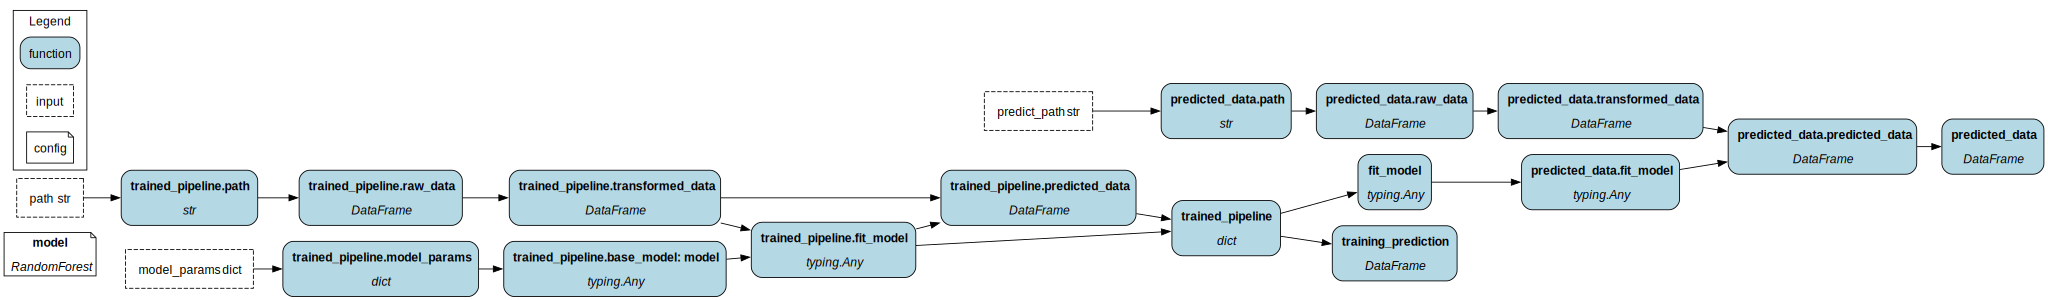

In [8]:
%%cell_to_module pipeline --config '{"model":"RandomForest"}' --display
from typing import Any

import pandas as pd

from hamilton.function_modifiers import subdag, extract_fields, value, source
import features
import train
import inference

@extract_fields(
    {'fit_model': Any, 'training_prediction': pd.DataFrame}
)
@subdag(
    features, train, inference,
    inputs={
        "path": source("path"),
        "model_params": source("model_params"),
    },
    # there are several ways to pass in configuration.
    # config={ 
    #     "model": source("model")
    # },
)
def trained_pipeline(fit_model: Any, predicted_data: pd.DataFrame) -> dict:
    return {'fit_model': fit_model, 'training_prediction': predicted_data}

@subdag(
    features, inference,
    inputs={
        "path": source("predict_path"),
        "fit_model": source("fit_model"),
    },
)
def predicted_data(predicted_data: pd.DataFrame) -> pd.DataFrame:
    return predicted_data

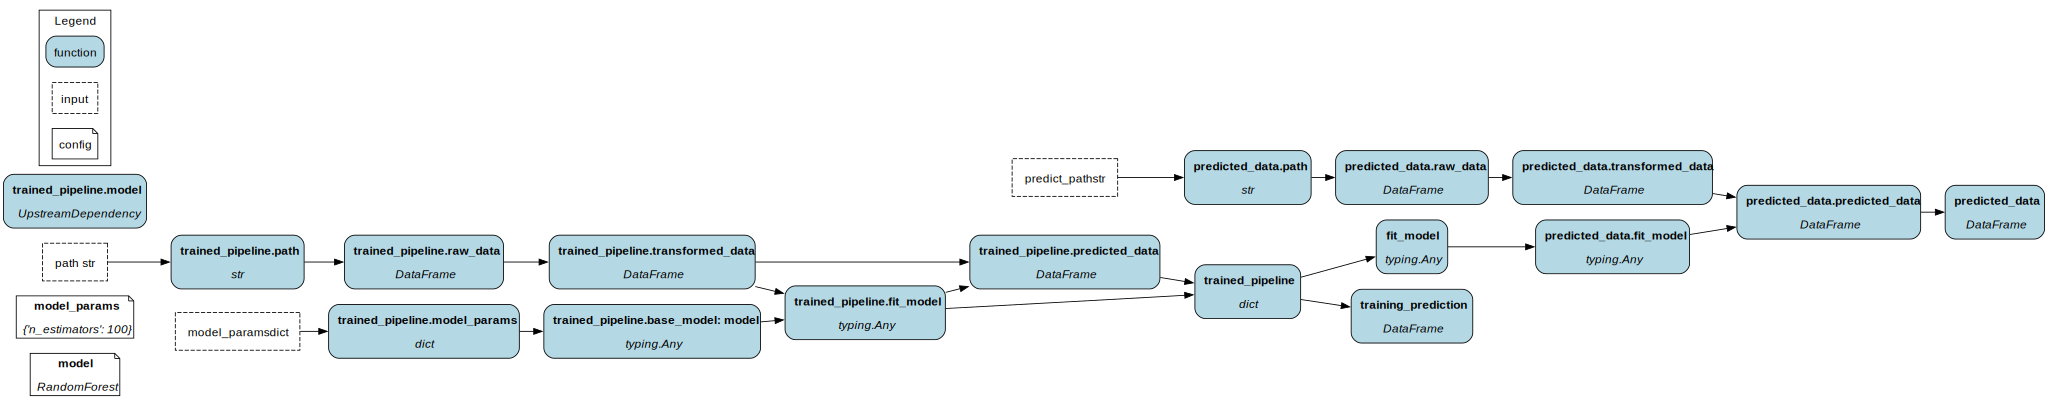

In [6]:
from hamilton import driver

dr = (
    driver.Builder()
    .with_config({"model": "RandomForest", "model_params": {"n_estimators": 100}})
    .with_modules(pipeline)
    .build()
)
dr.display_all_functions()

In [7]:
# this wont work because we don't actually have data...
# dr.execute(["trained_pipeline", "predicted_data"], 
#            inputs={"path": "data.csv", "predict_path": "data.csv"})